In [ ]:
!pip install -q kaggle

In [ ]:
#!/bin/bash
!kaggle datasets download riyaelizashaju/skin-disease-classification-image-dataset

: 

In [3]:
!unzip skin-disease-classification-image-dataset.zip -d dataset

Archive:  skin-disease-classification-image-dataset.zip
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0024468.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0024470.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0024707.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0024763.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0024771.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0024800.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0024913.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0024948.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0025780.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0025953.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0025957.jpg  
  inflating: dataset/Split_smol/train/Actinic keratosis/ISIC_0025992.jpg  
  inflating: dataset/Split_smol/train/Actini

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [2]:

# Set directories
train_dir = "/content/dataset/Split_smol/train"
val_dir = "/content/dataset/Split_smol/val"

# Define classes
selected_classes = ["Actinic keratosis", "Atopic Dermatitis", "Benign keratosis", "Dermatofibroma"]

In [3]:
# Enhanced Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    channel_shift_range=0.2,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, classes=selected_classes, class_mode='categorical')
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, classes=selected_classes, class_mode='categorical')


Found 321 images belonging to 4 classes.
Found 81 images belonging to 4 classes.


In [4]:

# Load Pretrained DenseNet201 Model
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(selected_classes), activation='softmax')(x)

# Model Compilation
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 18,822,468 (71.80 MB)

 Trainable params: 496,644 (1.89 MB)

 Non-trainable params: 18,325,824 (69.91 MB)

In [5]:

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint("densenet201_best_model.keras", monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]

# Training
history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=callbacks)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 110s 7s/step - accuracy: 0.3262 - loss: 1.7068 - val_accuracy: 0.4815 - val_loss: 1.1905 - learning_rate: 1.0000e-04
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 447ms/step - accuracy: 0.4216 - loss: 1.3522 - val_accuracy: 0.6173 - val_loss: 1.0316 - learning_rate: 1.0000e-04
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 507ms/step - accuracy: 0.5365 - loss: 1.0516 - val_accuracy: 0.6667 - val_loss: 0.9310 - learning_rate: 1.0000e-04
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 459ms/step - accuracy: 0.6730 - loss: 0.7830 - val_accuracy: 0.6914 - val_loss: 0.8583 - learning_rate: 1.0000e-04
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 420ms/step - accuracy: 0.6614 - loss: 0.7871 - val_accuracy: 0.6914 - val_loss: 0.8042 - learning_rate: 1.0000e-04
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 461ms/step - accuracy: 0.7193 - loss: 0.6590 - val_accuracy: 0.7160 - val_loss: 0.7569 - learning_rate: 1.0000e-04
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 555ms/step - accuracy: 0.7621 

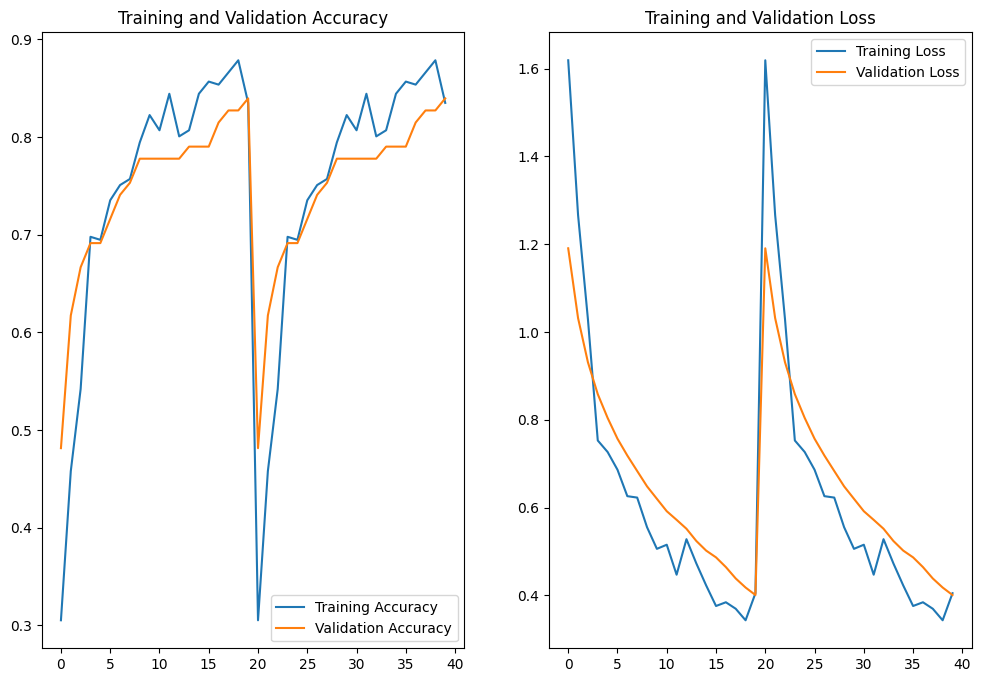

In [8]:
# Plot Training History
def plot_training_history(history, fhistory):
    acc = history.history['accuracy'] + fhistory.history['accuracy']
    val_acc = history.history['val_accuracy'] + fhistory.history['val_accuracy']
    loss = history.history['loss'] + fhistory.history['loss']
    val_loss = history.history['val_loss'] + fhistory.history['val_loss']
    epochs_range = range(len(acc))
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
plot_training_history(history,history)



**Finetuning the Model**

In [9]:

# Fine-Tuning (Unfreeze Last 50 Layers)
for layer in base_model.layers[-50:]:
    layer.trainable = True
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
fine_tune_history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=callbacks)


Epoch 1/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step - accuracy: 0.8618 - loss: 0.4080 - val_accuracy: 0.8519 - val_loss: 0.3818 - learning_rate: 1.0000e-05
Epoch 2/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 489ms/step - accuracy: 0.8888 - loss: 0.2995 - val_accuracy: 0.8395 - val_loss: 0.3683 - learning_rate: 1.0000e-05
Epoch 3/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 571ms/step - accuracy: 0.8397 - loss: 0.3934 - val_accuracy: 0.8519 - val_loss: 0.3569 - learning_rate: 1.0000e-05
Epoch 4/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 573ms/step - accuracy: 0.8843 - loss: 0.3388 - val_accuracy: 0.8519 - val_loss: 0.3513 - learning_rate: 1.0000e-05
Epoch 5/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 511ms/step - accuracy: 0.8718 - loss: 0.2636 - val_accuracy: 0.8519 - val_loss: 0.3434 - learning_rate: 1.0000e-05
Epoch 6/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 492ms/step - accuracy: 0.9053 - loss: 0.3156 - val_accuracy: 0.8519 - val_loss: 0.3354 - learning_rate: 1.0000e-05
Epoch 7/20
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 557ms/step - accura

In [10]:

# Save Model
model.save("densenet201_dermatitis_model.keras")

# Model Evaluation
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.9070 - loss: 0.2540
Validation Loss: 0.2841, Validation Accuracy: 0.8765


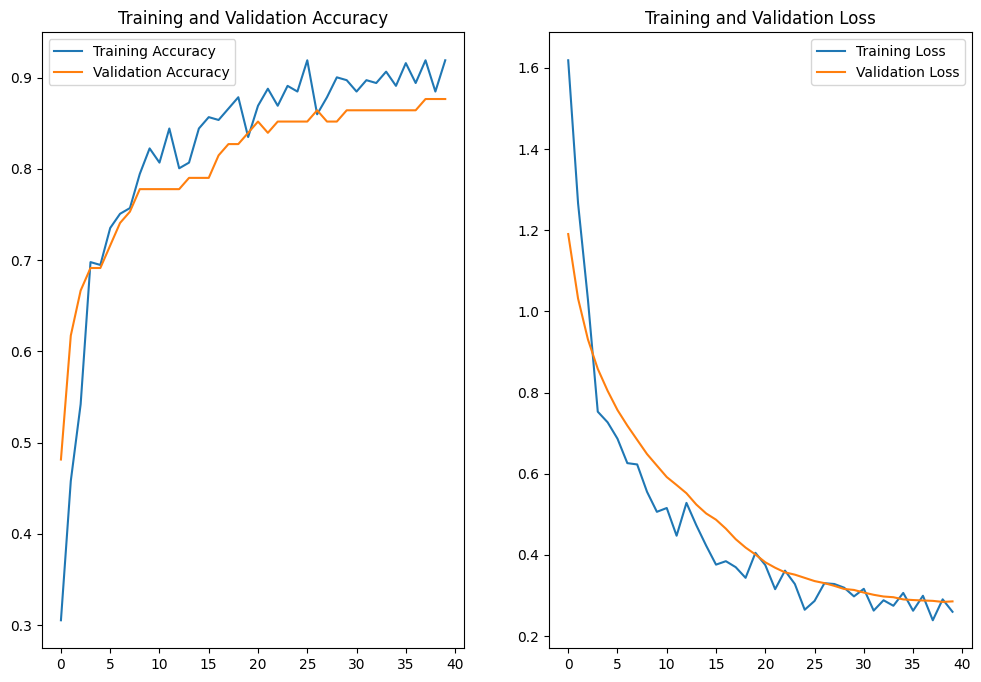

In [11]:

# Plot Training History
def plot_training_history(history, fine_tune_history):
    acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
    val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']
    loss = history.history['loss'] + fine_tune_history.history['loss']
    val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']
    epochs_range = range(len(acc))
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()
plot_training_history(history, fine_tune_history)

3/3 ━━━━━━━━━━━━━━━━━━━━ 38s 8s/step


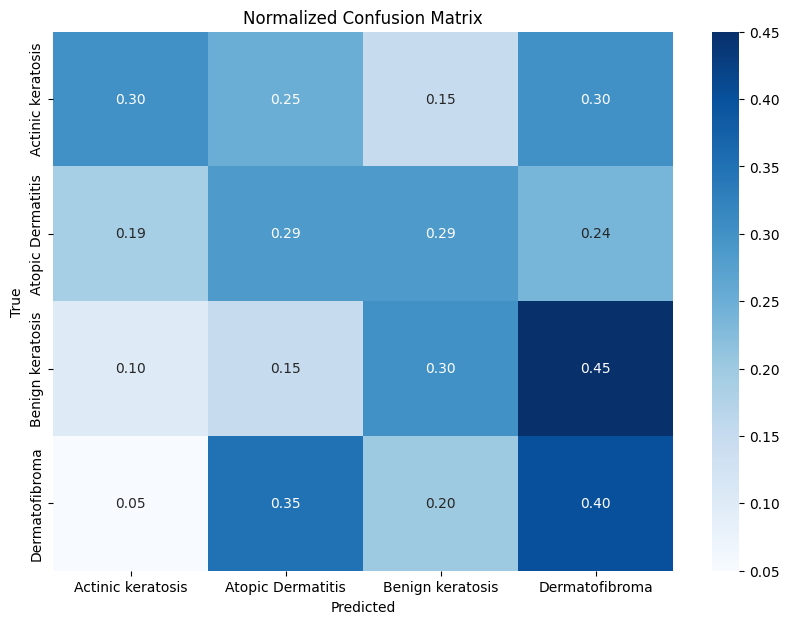

In [12]:

# Confusion Matrix & Classification Report
true_labels = val_generator.classes
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)
cm = confusion_matrix(true_labels, predicted_classes, normalize='true')
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

In [13]:

# Classification Report
report = classification_report(true_labels, predicted_classes, target_names=val_generator.class_indices.keys())
print("Classification Report:")
print(report)


Classification Report:
                   precision    recall  f1-score   support

Actinic keratosis       0.46      0.30      0.36        20
Atopic Dermatitis       0.29      0.29      0.29        21
 Benign keratosis       0.32      0.30      0.31        20
   Dermatofibroma       0.29      0.40      0.33        20

         accuracy                           0.32        81
        macro avg       0.34      0.32      0.32        81
     weighted avg       0.34      0.32      0.32        81



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


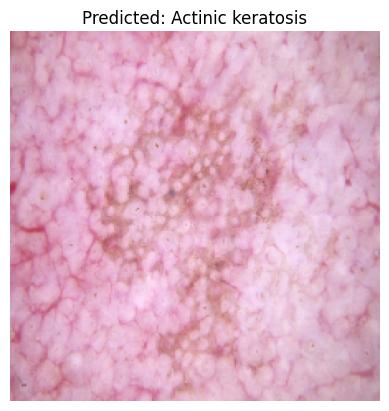

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
# Load and preprocess a single test image
def predict_single_image(image_path, model):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    class_labels = list(val_generator.class_indices.keys())
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_labels[predicted_class]}")
    plt.show()

# Example usage
test_image_path = "/content/dataset/Split_smol/val/Actinic keratosis/ISIC_0026212.jpg"
predict_single_image(test_image_path, model)